In [42]:
import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import random

In [43]:
batch_size = 32  # how many samples per batch to load
iid = 0 # if the data is i.i.d or not
unbalanced = 1 # in non i.i.d. setting split the data between clients equally or not
num_users = 100 # number of client

In [44]:
if iid:
    from utils_v2 import get_dataset, average_weights, exp_details
else:
    from utils import get_dataset, average_weights, exp_details

In [45]:
# for REPRODUCIBILITY https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(0)

g = torch.Generator()
g.manual_seed(0)

np.random.seed(0)

In [46]:
train_dataset, test_dataset, user_groups = get_dataset(iid=iid, unbalanced=unbalanced,
                                                       num_users=num_users)

Files already downloaded and verified
Files already downloaded and verified


In [47]:
class DatasetSplit(Dataset):
    """
    An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [48]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [49]:
def get_dataloader(dataset, idxs):
    trainloader = DataLoader(DatasetSplit(dataset, idxs),
                             batch_size=batch_size, shuffle=True, generator=g,
                             worker_init_fn=seed_worker)

    return trainloader

In [50]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [51]:
user_lables = dict()
user_mean = dict()
user_std = dict()

for idx in user_groups.keys():
    labels_list = []
    #trainloader, _ = get_dataloader(train_dataset, user_groups[idx])
    trainloader = get_dataloader(train_dataset, user_groups[idx])
    mean = 0.0
    std = 0.0
    for data, target in trainloader:
        for i in range(len(data)):
            label = target.data[i]
            labels_list.append(classes[int(label)])

        # compute mean and std variation
        images = data.view(data.size(0), data.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(trainloader.dataset)
    std /= len(trainloader.dataset)

    user_mean[idx] = mean.numpy()
    user_std[idx] = std.numpy()

    user_lables[idx] = labels_list

C:\Users\david\AppData\Local\Temp\ipykernel_18976\3803027819.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


In [52]:
user_std[0]

array([1.2463989, 1.2591885, 1.2550025], dtype=float32)

In [53]:
def count_labels(user_labels, classes):
    user_labels_count = dict()
    for idx in user_groups.keys():
        elements_count = {}
        # iterating over the elements for frequency
        for element in user_labels[idx]:
            # checking whether it is in the dict or not
            if element in elements_count:
                # incerementing the count by 1
                elements_count[element] += 1
            else:
                # setting the count to 1
                elements_count[element] = 1

        user_labels_count[idx] = elements_count

    return user_labels_count

user_labels_count = count_labels(user_lables, classes)

In [54]:
import pandas as pd

data = pd.DataFrame.from_dict(user_labels_count, orient="index")

In [55]:
data.sum()

airplane      5000.0
frog          5000.0
cat           5000.0
truck         5000.0
dog           5000.0
bird          5000.0
horse         5000.0
deer          5000.0
automobile    5000.0
ship          5000.0
dtype: float64

In [56]:
data

,airplane,frog,cat,truck,dog,bird,horse,deer,automobile,ship
0,200.0,50.0,50.0,50.0,50.0,50.0,NaN,NaN,NaN,NaN
1,150.0,50.0,NaN,50.0,NaN,150.0,50.0,50.0,50.0,NaN
2,100.0,50.0,100.0,100.0,50.0,150.0,100.0,50.0,NaN,100.0
4,50.0,NaN,NaN,NaN,50.0,NaN,50.0,NaN,NaN,NaN
5,300.0,150.0,50.0,100.0,100.0,50.0,50.0,100.0,50.0,50.0
...,...,...,...,...,...,...,...,...,...,...
90,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN


In [57]:
data.isna()

,airplane,frog,cat,truck,dog,bird,horse,deer,automobile,ship
0,False,False,False,False,False,False,True,True,True,True
1,False,False,True,False,True,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True,False
4,False,True,True,True,False,True,False,True,True,True
5,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
90,True,True,True,True,True,True,False,True,True,True
3,True,True,True,True,True,True,True,False,True,True
50,True,True,True,True,True,True,True,False,True,True
19,True,True,True,True,True,True,True,True,False,True


In [58]:
class_each_user = [ (10 - data.isna().values[i].sum()) for i in range(len(data)) ]
print(np.mean(class_each_user))
print(np.std(class_each_user))

5.72
2.630893384384856


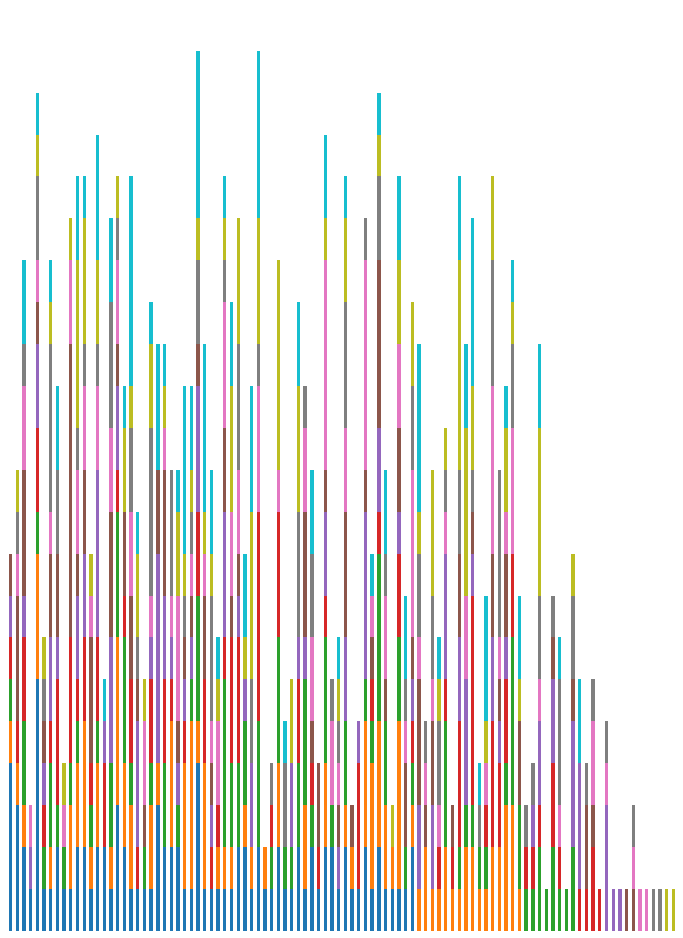

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 17))

data.plot.bar(stacked=True, ax=ax)

# plt.title("IID")
plt.ylabel('Images')
plt.xlabel('Users')

plt.axis('off')
plt.legend('',frameon=False)

# plt.annotate(f"mean: {np.mean(class_each_user).round(2)}\nstd: {np.std(class_each_user).round(2)}", xy=(0.875, 0.965), xycoords='axes fraction', weight="bold", size=14, bbox=dict(facecolor='none',boxstyle="square,pad=0.3"))

plt.savefig("data_distribution/nonIID_unbalanced_long.png")
# plt.savefig("data_distribution/new_random_seed/test.png")